In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
np.random.seed(42)
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X, y = load_digits(return_X_y=True)
X = MinMaxScaler().fit_transform(X)

DROP_LABELS = int(0.95 * len(y))
idx = np.random.choice(len(y), DROP_LABELS, replace=False)
y_full = y.copy()
y[idx] = -1

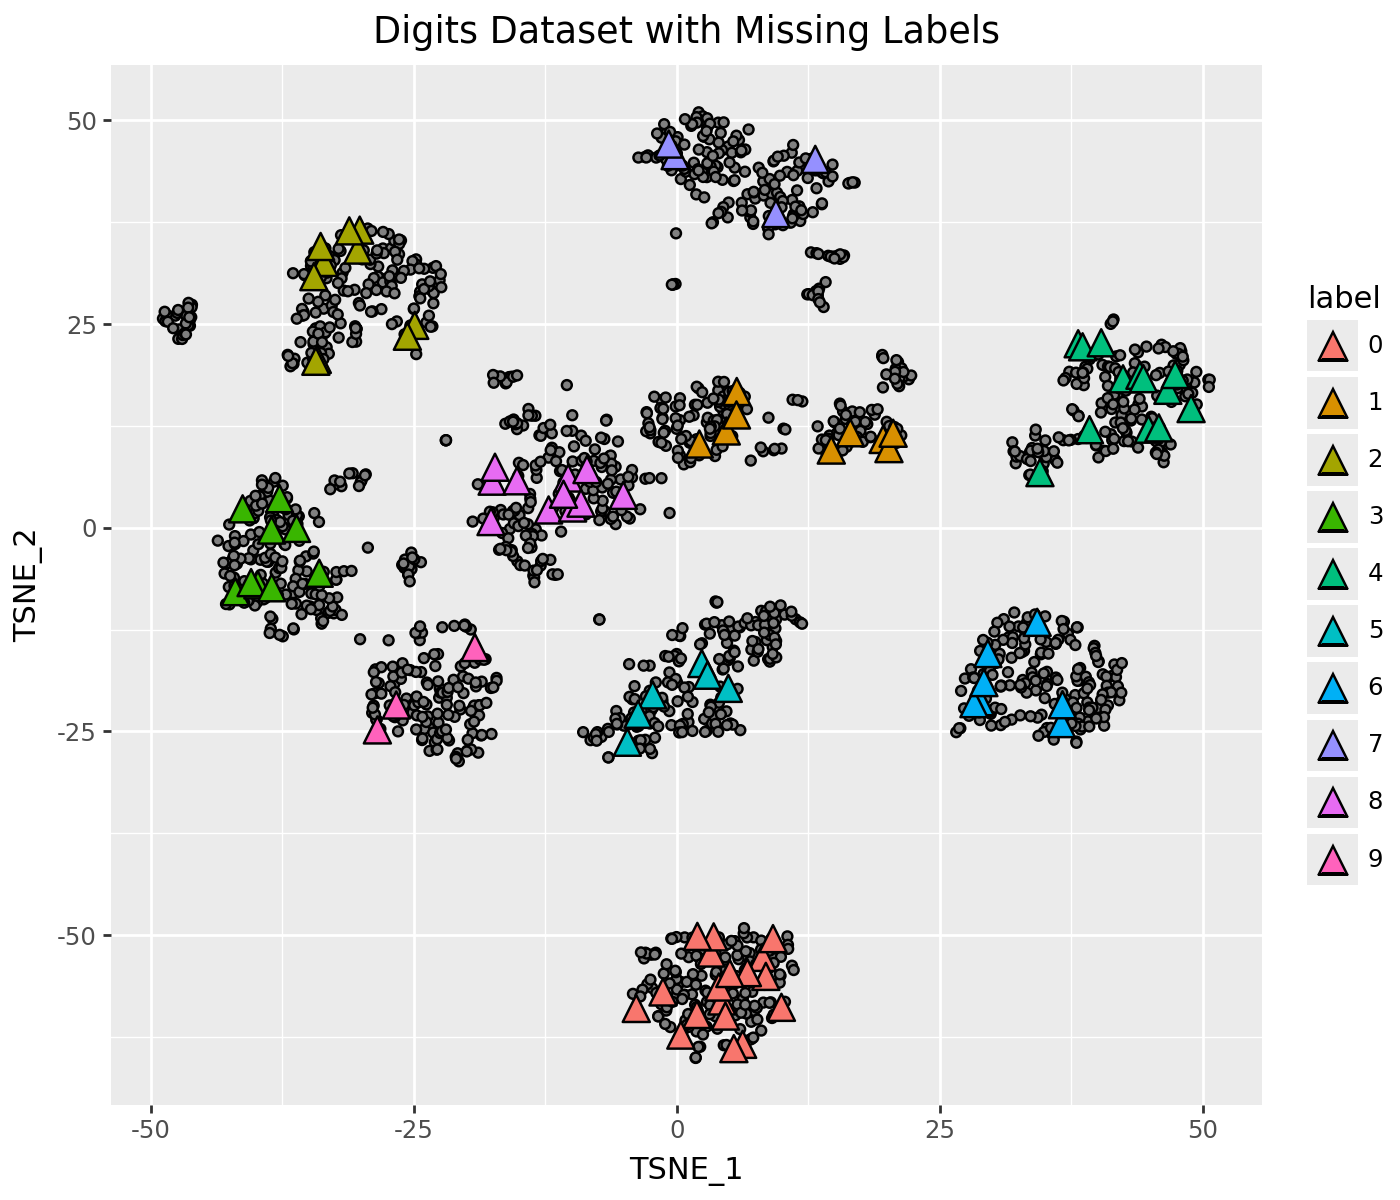

In [2]:
import pandas as pd
from sklearn.manifold import TSNE
from plotnine import *

X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)
df = pd.DataFrame(X_2d, columns=['TSNE_1', 'TSNE_2'])
df['label'] = y.astype(str)
df['has_label'] = df['label'] != '-1'

(ggplot(df, aes(x='TSNE_1', y='TSNE_2', fill='label'))
    + geom_point(data=df[df['has_label'] == False], fill='gray') 
    + geom_point(data=df[df['has_label'] == True], shape='^', size=5) 
    + theme(figure_size=(7, 6))
    + labs(title='Digits Dataset with Missing Labels')
)

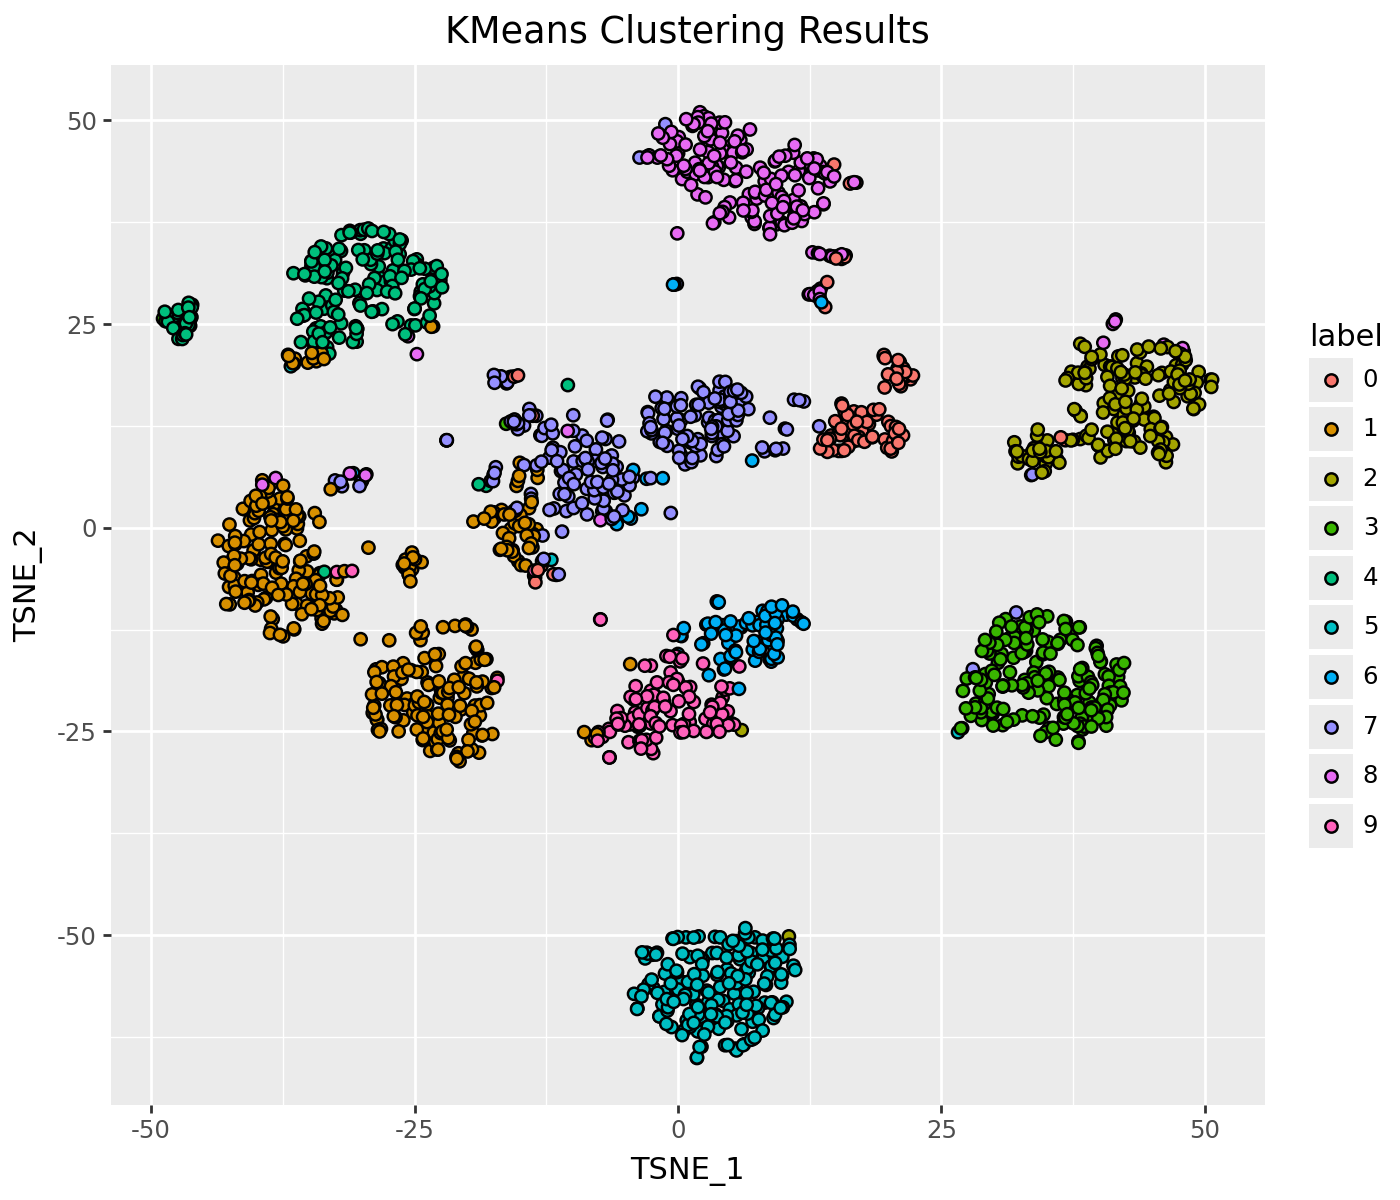

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)

kmeans.fit(X)
y_kmeans = kmeans.predict(X)

df_clus = pd.DataFrame(X_2d, columns=['TSNE_1', 'TSNE_2'])
df_clus['label'] = y_kmeans.astype(str)
df_clus['has_label'] = df['has_label']

(ggplot(df_clus)
    + aes(x='TSNE_1', y='TSNE_2', fill='label')
    + geom_point(size=2) 
    + theme(figure_size=(7, 6))
    + labs(title='KMeans Clustering Results')
)

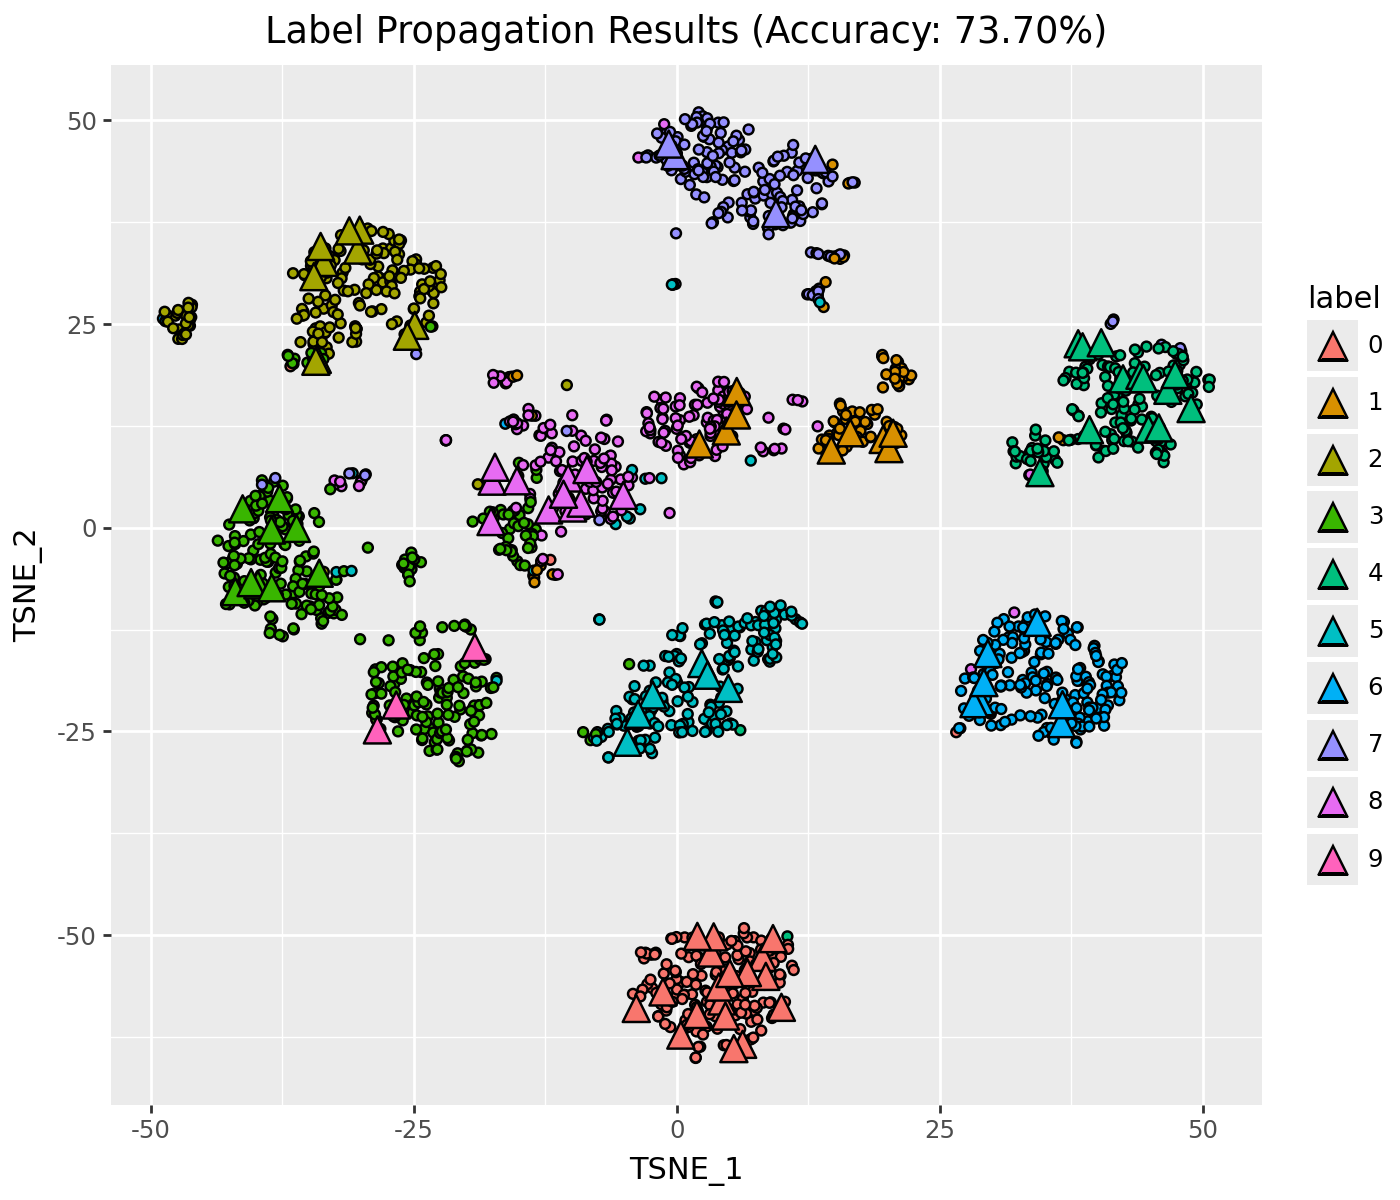

In [4]:
from sklearn.metrics import pairwise_distances_argmin_min

def label_propagation(X, y):
    n_clusters = len(np.unique(y[y != -1]))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_kmeans = kmeans.fit_predict(X)
    y_pred = np.zeros_like(y)
    
    for label in range(n_clusters):
        y_clus = y[y_kmeans == label]
        
        if y_clus[y_clus != -1].size == 0:
            y_pred[y_kmeans == label] = -1
        else:
            y_pred[y_kmeans == label] = np.bincount(y_clus[y_clus != -1]).argmax()
            
    if np.any(y_pred == -1):
        for cluster_label in np.unique(y_kmeans[y_pred == -1]):
            centroid = kmeans.cluster_centers_[cluster_label].reshape(1, -1)
            labeled_clusters = np.unique(y_kmeans[y_pred != -1])
            closest_cluster = pairwise_distances_argmin_min(centroid, kmeans.cluster_centers_[labeled_clusters])[0]
            y_pred[y_kmeans == cluster_label] = y_pred[y_kmeans == closest_cluster][0]
        
    return y_pred

df_pred = pd.DataFrame(X_2d, columns=['TSNE_1', 'TSNE_2'])

y_pred = label_propagation(X, y)
df_pred['label'] = y_pred.astype(str)
df_pred['has_label'] = df['has_label']

accuracy = np.mean(y_pred[y == -1] == y_full[y == -1])

(ggplot(df_pred, aes(x='TSNE_1', y='TSNE_2', fill='label'))
    + geom_point(data=df_pred[df['has_label'] == False],) 
    + geom_point(data=df[df['has_label'] == True], shape='^', size=5) 
    + theme(figure_size=(7, 6))
    + labs(title=f'Label Propagation Results (Accuracy: {accuracy:.2%})')
)

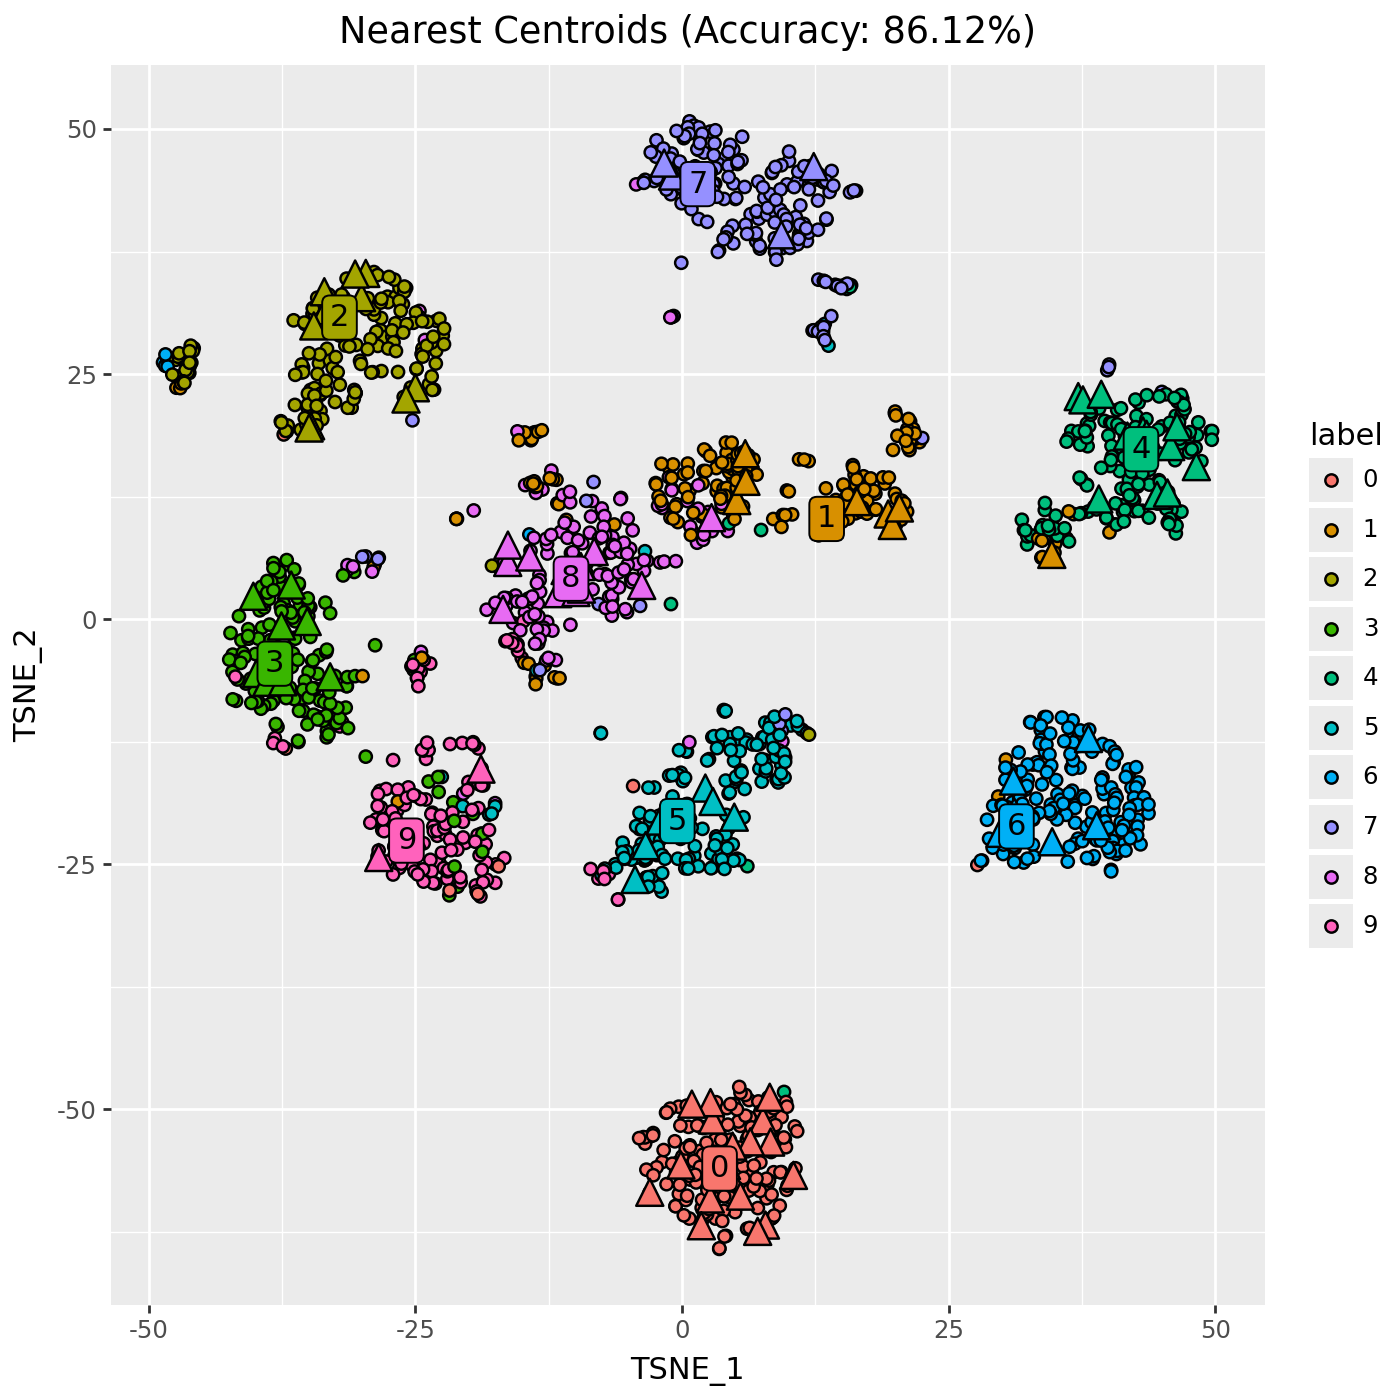

In [5]:
from sklearn.metrics import pairwise_distances_argmin_min

centroids = np.array([X[y == i].mean(axis=0) for i in range(10)])
closest, _ = pairwise_distances_argmin_min(X, centroids)

X_cat = np.concat([X, centroids], axis=0)
X_cat_2d = TSNE(n_components=2, random_state=42).fit_transform(X_cat)
df_cat = pd.DataFrame(X_cat_2d, columns=['TSNE_1', 'TSNE_2'])
df_cat['label'] = np.concat([closest, np.arange(10)], axis=0).astype(str)

accuracy = np.mean(closest[y == -1] == y_full[y == -1])

(ggplot(aes(x='TSNE_1', y='TSNE_2', fill='label'))
    + geom_point(data=df_cat.iloc[:-10][y == -1], size=2) 
    + geom_point(data=df_cat.iloc[:-10][y != -1], shape='^', size=5, show_legend=False) 
    + geom_label(data=df_cat.iloc[-10:], mapping=aes(label='label'), show_legend=False)
    + theme(figure_size=(7, 7))
    + labs(title=f'Nearest Centroids (Accuracy: {accuracy:.2%})')
)

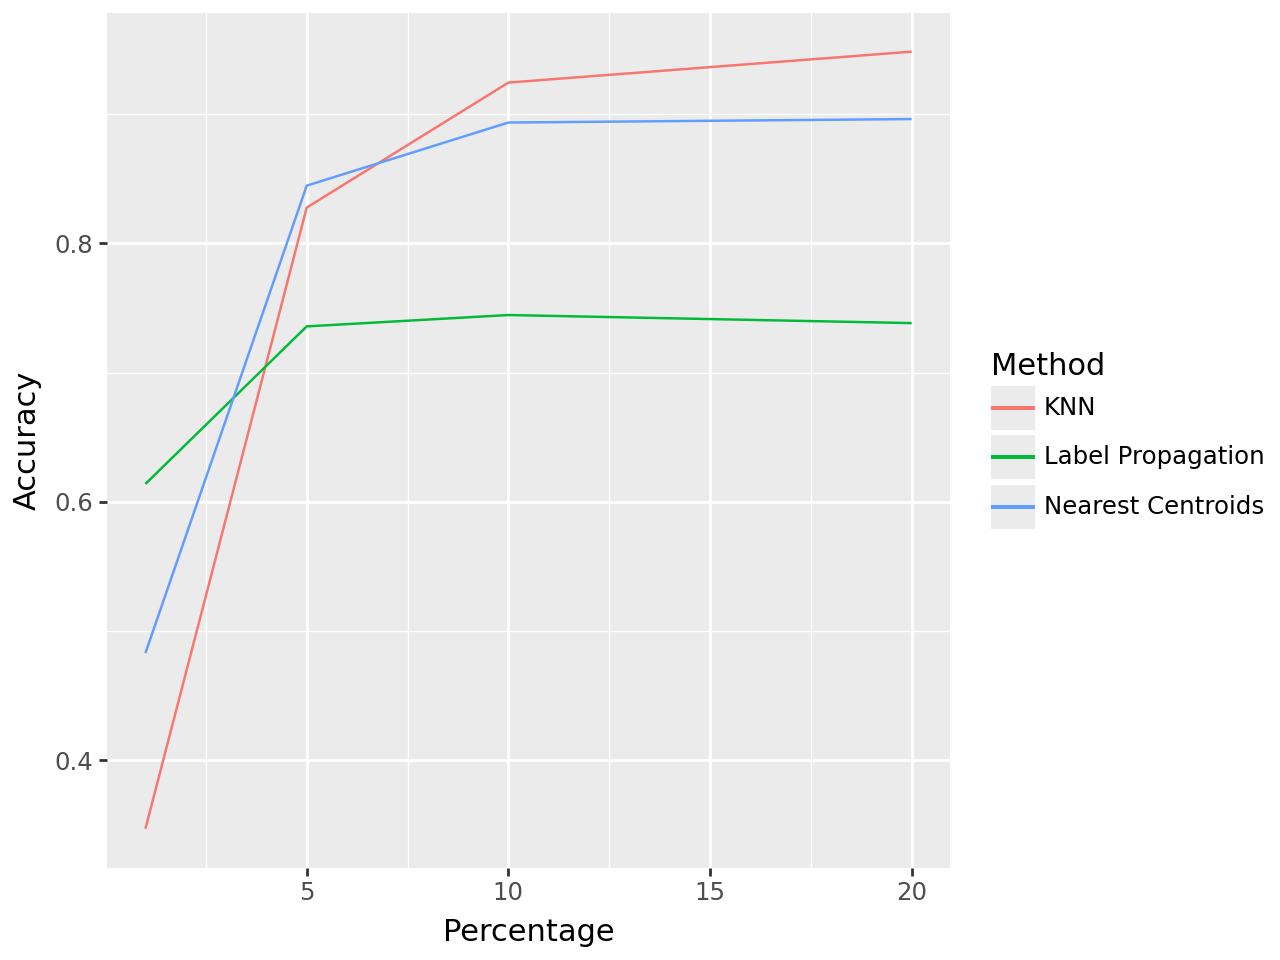

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def knn(X, y, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X[y != -1], y[y != -1])
    return knn.predict(X)

def nearest_centroids(X, y):
    centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y) if i != -1])
    closest, _ = pairwise_distances_argmin_min(X, centroids)
    return closest

p_acc, ncc_acc, knn_acc = [], [], []

for p in [0.01, 0.05, 0.1, 0.2]:
    y_sample = y_full.copy()
    idx = np.random.choice(len(y_sample), int((1 - p) * len(y_sample)), replace=False)
    y_sample[idx] = -1
    
    y_prop = label_propagation(X, y_sample)
    p_acc.append(np.mean(y_prop[y_sample == -1] == y_full[y_sample == -1]))
    
    y_ncc = nearest_centroids(X, y_sample)
    ncc_acc.append(np.mean(y_ncc[y_sample == -1] == y_full[y_sample == -1]))
    
    y_knn = knn(X, y_sample, n_neighbors=5)
    knn_acc.append(np.mean(y_knn[y_sample == -1] == y_full[y_sample == -1]))

df = pd.DataFrame({
    'Percentage': [1, 5, 10, 20],
    'Label Propagation': p_acc,
    'Nearest Centroids': ncc_acc,
    'KNN': knn_acc
})

(ggplot(df.melt(id_vars='Percentage', var_name='Method', value_name='Accuracy')) 
    + aes(x='Percentage', y='Accuracy', color='Method')
    + geom_line()
)